<a href="https://colab.research.google.com/github/dragonpuffle/Wolves-from-wall-street/blob/main/HM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Оптимальные портфели инвестиций





# Данные по дневным ценам активов и объемам продаж за 2016 год

In [ ]:
import os
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import yfinance as yf
from bs4 import BeautifulSoup
from scipy import stats
from scipy.stats import shapiro, normaltest
import scipy.optimize as optimize
from scipy.optimize import minimize

In [ ]:
pip install pyportfolioopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.1 MB/s eta 0:00:00


In [ ]:
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

Используя парсинг, выгружаем данные об активах, которые входят в NASDAQ-100 (включает 100 крупнейших компаний, исключая финансовые):

In [ ]:
def get_tickets_from_url(URL):
    names = []
    response = requests.get(URL)
    print('response status = ', response.status_code)
    soup = BeautifulSoup(response.content, "html5lib")
    items = soup.findAll('a', 'apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat')
    for item in items:
        names.append(item.text)
    print('number of stocks = ', len(names))

    return names


def download_data(URL, tickets_file, stocks_file):
    if not os.path.exists(tickets_file) or os.stat(tickets_file).st_size == 0:
        print('parcing tickets')
        tickets = get_tickets_from_url(URL)
        save_names_to_file(tickets, tickets_file)
        print('parcing tickets done')
    if not os.path.exists(stocks_file) or os.stat(stocks_file).st_size == 0:
        print('downloading stock data')
        tickets = get_names_from_file(tickets_file)
        download_stocks_to_excel(tickets, stocks_file)
        delete_null_columns(stocks_file)
        print('downloading stock data done')
        print('got data')
        print('stocks downloaded =', len(pd.read_excel(stocks_file).columns))
    print(len(get_names_from_file(tickets_file)))
    print(len(pd.read_excel(stocks_file).columns))


def save_names_to_file(names, file):
    with open(file, 'w'):
        pass

    with open(file, 'w') as fp:
        fp.write(' '.join(names))


def get_names_from_file(file):
    with open(file) as fp:
        names = fp.read().split(' ')
    return names


def update_file_names(in_file, out_file):
    save_names_to_file(in_file, out_file)
    return get_names_from_file(out_file)


def download_stocks_to_excel(names, xlsx_file):
    data = pd.DataFrame(columns=names)
    for name in names:
        data[name] = yf.download(name, '2016-01-01', '2016-12-31')['Adj Close']

    data.to_excel(xlsx_file, index=False)


def delete_null_columns(file):
    df = pd.read_excel(file)
    df_cleaned = df.dropna(axis=1, how='any')
    df_cleaned.to_excel(file, index=False)

os.makedirs('data2', exist_ok=True)
URL = 'https://ru.tradingview.com/symbols/NASDAQ-NDX/components/'
tickets_file = 'data2/tickets.txt'
stocks_file = 'data2/stocks.xlsx'

download_data(URL, tickets_file, stocks_file)

parcing tickets
response status =  200
number of stocks =  100
parcing tickets done
downloading stock data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

downloading stock data done
got data
stocks downloaded = 87
100
87


Преобразовываем данные по ценам, используя логарифмическую доходность. И  вычисляем оценки ожидаемых доходностей и стандартных отклонений:

In [ ]:
def profitability(file_in, file_out):
    if not os.path.exists(file_out) or os.stat(file_out).st_size == 0:
        data = pd.read_excel(file_in)
        for i in range(len(data.columns)):
            data.iloc[:, i] = np.log1p(data.iloc[:, i].pct_change())
        data.to_excel(file_out, index=False)

def calculate_mean_var(file_in, file_out):
    if not os.path.exists(file_out) or os.stat(file_out).st_size == 0:
        df = pd.read_excel(file_in)
        result = []

        for column in df.columns[1:]:
            stock_name = df[column].name
            mean = np.mean(df[column])
            variance = np.var(df[column])

            result.append({
                'Название акции': stock_name,
                'Мат ожидание': mean,
                'Дисперсия': variance})

        result_df = pd.DataFrame(result)

        result_df.to_excel(file_out, index=False)

pr_file2 = 'data2/profitability.xlsx'
mean_var = 'data2/mean_var.xlsx'

profitability(stocks_file, pr_file2)
calculate_mean_var(pr_file2, mean_var)

Из полученных данных отбираем 50 лучших акций с точки зрения коэффициента Шарпа (показывает, насколько хорошо прибыль компенсирует риск, т.е. отбираем наиболее эффективные активы, которые обеспечивают хорошее соотношение доходности и волатильности) и подготавливаем данные для дальнейшего использования:

In [ ]:
def find_50stocks(stocks_file, pr_file2, mean_var_file, tickets_file50, stocks_file50, pr_file50, mean_var50,
                  risk_free_rate=0.01):
    if not os.path.exists(tickets_file50) or os.stat(tickets_file50).st_size == 0:
        df = pd.read_excel(mean_var_file)
        # Убираем акции с отрицательным мат ожиданием и слишком высокой дисперсией
        acceptable = df[(df['Мат ожидание'] > 0.0001) & (df['Дисперсия'] < 0.001)]
        # Рассчитываем коэффициент Шарпа (Sharpe Ratio = (Мат ожидание - Безрисковая ставка) / Стандартное отклонение)
        acceptable['Sharpe Ratio'] = (acceptable['Мат ожидание'] - risk_free_rate) / acceptable['Дисперсия'] ** 0.5
        acceptable = acceptable.sort_values(by='Sharpe Ratio', ascending=False)
        acceptable50 = acceptable['Название акции'].head(50)
        save_names_to_file(acceptable50, tickets_file50)

    acceptable50 = get_names_from_file(tickets_file50)

    if not os.path.exists(stocks_file50) or os.stat(stocks_file50).st_size == 0:
        df2 = pd.read_excel(stocks_file)
        columns = df2.columns[df2.columns.isin(acceptable50)]
        df2 = df2[columns]
        df2.to_excel(stocks_file50, index=False)

    if not os.path.exists(pr_file50) or os.stat(pr_file50).st_size == 0:
        df2 = pd.read_excel(pr_file2)
        columns = df2.columns[df2.columns.isin(acceptable50)]
        df2 = df2[columns]
        df2.to_excel(pr_file50, index=False)

    if not os.path.exists(mean_var50) or os.stat(mean_var50).st_size == 0:
        df2 = pd.read_excel(mean_var_file)
        df2 = df2[df2['Название акции'].isin(acceptable50)]
        df2.to_excel(mean_var50, index=False)

    print(len(get_names_from_file(tickets_file50)))


tickets_file50 = 'data2/tickets50.txt'
stocks_file50 = 'data2/stocks50.xlsx'
pr_file50 = 'data2/profitability50.xlsx'
mean_var50 = 'data2/mean_var50.xlsx'

find_50stocks(stocks_file, pr_file2, mean_var, tickets_file50, stocks_file50, pr_file50, mean_var50)

<ipython-input-7-dff7a42e47c9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acceptable['Sharpe Ratio'] = (acceptable['Мат ожидание'] - risk_free_rate) / acceptable['Дисперсия'] ** 0.5


50


# Портфели с минимальным риском

Вычисляем ковариационную матрицу:

In [ ]:
def calculate_cov(file_in, file_out):
    if not os.path.exists(file_out) or os.stat(file_out).st_size == 0:
        df = pd.read_excel(file_in)
        cov_matrix = df.cov()
        cov_matrix.to_excel(file_out, index=False)


cov_file50 = 'data2/cov_file.xlsx'

num_assets = len(pd.read_excel(pr_file50).columns)
calculate_cov(pr_file50, cov_file50)

Вычисляем портфель с минимальным риском с разрешением коротких продаж:


In [ ]:
# Вычисляем риск
def portfolio_risk(weights, cov_file50):
    cov_matrix = pd.read_excel(cov_file50)
    # Проверяем, что сумма весов = 1
    weights = np.array(weights)
    if not np.isclose(np.sum(weights), 1):
        raise ValueError("Сумма весов портфеля должна быть равна 1.")

    # Расчёт риска портфеля (через стандартное отклонение)
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Минимизируем риск портфеля
def minimize_risk_with_short_sales(cov_file50, portfolio_short_file):
    if not os.path.exists(portfolio_short_file) or os.stat(portfolio_short_file).st_size == 0:
        cov_matrix = pd.read_excel(cov_file50)
        num_assets = cov_matrix.shape[0]
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # это ограничение, сумма весов = 1
        bounds = tuple((-1, 1) for x in range(num_assets))  # это границы, разрешение коротких продаж
        initializer = num_assets * [1. / num_assets, ]  # равномерное распределение начальных весов
        result = optimize.minimize(portfolio_risk, initializer, args=(cov_file50,),
                                   method='SLSQP', bounds=bounds, constraints=constraints)
        #SLSQP — последовательное квадратичное программирование с ограничениями, ньютоновский метод решения системы Лагранжа
        res = pd.DataFrame(result.x)
        res.to_excel(portfolio_short_file)

# Расчитываем характеристики портфеля
def portfolio(weights, returns_file):
    weights = np.array(weights)
    returns = pd.read_excel(returns_file)
    port_return = np.sum(returns.mean() * weights) * 252 #доходность
    port_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights))) #волатильность
    sharpe = port_return / port_vol #коэф Шарпа
    return port_return, port_vol, sharpe


portfolio_min_risk_short_file = 'data2/portfolio_min_risk_short.xlsx'
minimize_risk_with_short_sales(cov_file50, portfolio_min_risk_short_file)
weights_min_risk_short = pd.read_excel(portfolio_min_risk_short_file)[0]
port_min_risk_return_short, port_min_risk_vol_short, sharpe_min_risk_short = portfolio(weights_min_risk_short, pr_file50)
print(port_min_risk_return_short, port_min_risk_vol_short, sharpe_min_risk_short)

0.18441497334394802 0.09982649958263158 1.8473549019045605


In [ ]:
tickets=get_names_from_file(tickets_file50)
print(list(zip(tickets, weights_min_risk_short)))

[('NVDA', -0.01491963144965999), ('FANG', -0.04640397615239869), ('NFLX', -0.009134056102681021), ('BKR', 0.009760253181222237), ('MRVL', -0.04465616190889458), ('ON', -0.006750761891658245), ('MELI', -0.007094168489304465), ('AMAT', -0.0235597680609844), ('NXPI', -0.08093803257249618), ('ADSK', 0.06564726365481595), ('CHTR', 0.068489700136783), ('LULU', 0.06999940042847923), ('TTWO', 0.120740592841304), ('TMUS', 0.2099647698427673), ('AVGO', -0.07677415146192282), ('LRCX', -0.007302937039685208), ('QCOM', 0.02499893318225123), ('BKNG', 0.2831440721085397), ('WBD', -0.2384057781966341), ('IDXX', -0.02087658072140933), ('ODFL', -0.04256743169830757), ('EA', -0.14031210622051), ('AMZN', 0.1036096077066718), ('CSX', 0.04687944712671602), ('ASML', 0.05776901493704117), ('MCHP', 0.02125464608074271), ('PCAR', 0.07670600772367209), ('PYPL', -0.0208932372698594), ('META', -0.01904296014962755), ('MAR', -0.02577690340136861), ('MDLZ', -0.09321061776616991), ('ADI', 0.008159388064053683), ('FAS

Визуализируем распределение весов активов в данном портфеле:

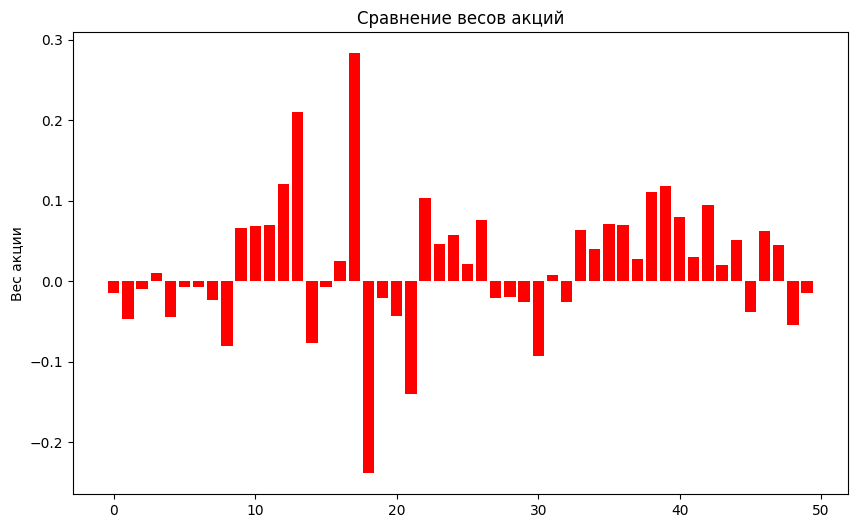

In [ ]:
def create_bar_graph_weight(optimal_weights):
    plt.figure(figsize=(10, 6))
    tickets = range(0, 50)
    plt.bar(tickets, optimal_weights, color=['red'])
    plt.title('Сравнение весов акций')
    plt.ylabel('Вес акции')
    plt.show()

create_bar_graph_weight(weights_min_risk_short)

Вычисляем портфель с минимальным риском с запретом коротких продаж:

In [ ]:
def minimize_risk_without_short_sales(cov_file50, portfolio_no_short_file):
    if not os.path.exists(portfolio_no_short_file) or os.stat(portfolio_no_short_file).st_size == 0:
        cov_matrix = pd.read_excel(cov_file50)
        num_assets = cov_matrix.shape[0]
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for asset in range(num_assets))  # запрет коротких продаж
        initializer = num_assets * [1. / num_assets, ]
        result = optimize.minimize(portfolio_risk, initializer, args=(cov_file50,),
                                   method='SLSQP', bounds=bounds, constraints=constraints)
        res = pd.DataFrame(result.x)
        res.to_excel(portfolio_no_short_file)


portfolio_min_risk_no_short_file = 'data2/portfolio_min_risk_no_short.xlsx'

minimize_risk_without_short_sales(cov_file50, portfolio_min_risk_no_short_file)
weights_min_risk_no_short = pd.read_excel(portfolio_min_risk_no_short_file)[0]
port_min_risk_return_no_short, port_min_risk_vol_no_short, sharpe_min_risk_no_short = portfolio(weights_min_risk_no_short, pr_file50)
print(port_min_risk_return_no_short, port_min_risk_vol_no_short, sharpe_min_risk_no_short)

0.21859874011481817 0.12642820662768786 1.7290345718385354


In [ ]:
tickets=get_names_from_file(tickets_file50)
print(list(zip(tickets, weights_min_risk_no_short)))

[('NVDA', 9.535866268188672e-18), ('FANG', 0.0), ('NFLX', 3.708877964867548e-18), ('BKR', 0.0), ('MRVL', 0.0), ('ON', 0.0), ('MELI', 4.008981224431138e-18), ('AMAT', 7.57029465475825e-19), ('NXPI', 0.0), ('ADSK', 0.02933881230755798), ('CHTR', 0.0), ('LULU', 3.880627784608345e-19), ('TTWO', 1.265756793441428e-17), ('TMUS', 0.1242684093853659), ('AVGO', 6.251131787165055e-18), ('LRCX', 2.640388853787484e-18), ('QCOM', 0.0), ('BKNG', 0.07035526148697159), ('WBD', 1.38567999297738e-17), ('IDXX', 2.012194297423653e-17), ('ODFL', 0.0), ('EA', 0.0), ('AMZN', 0.1121677552576273), ('CSX', 0.0), ('ASML', 0.0), ('MCHP', 0.0), ('PCAR', 0.1078786827889204), ('PYPL', 0.0), ('META', 8.544913075787383e-19), ('MAR', 2.572722251696261e-18), ('MDLZ', 1.279394907508525e-18), ('ADI', 0.02262441544482119), ('FAST', 0.0), ('CDW', 0.03526470320183223), ('ADBE', 0.01414768471600624), ('CPRT', 0.1189241679565202), ('EXC', 0.06595473987014304), ('MSFT', 0.0), ('TXN', 0.04934394143293603), ('CDNS', 5.39181328599

Визуализируем распределение весов активов в данном портфеле:

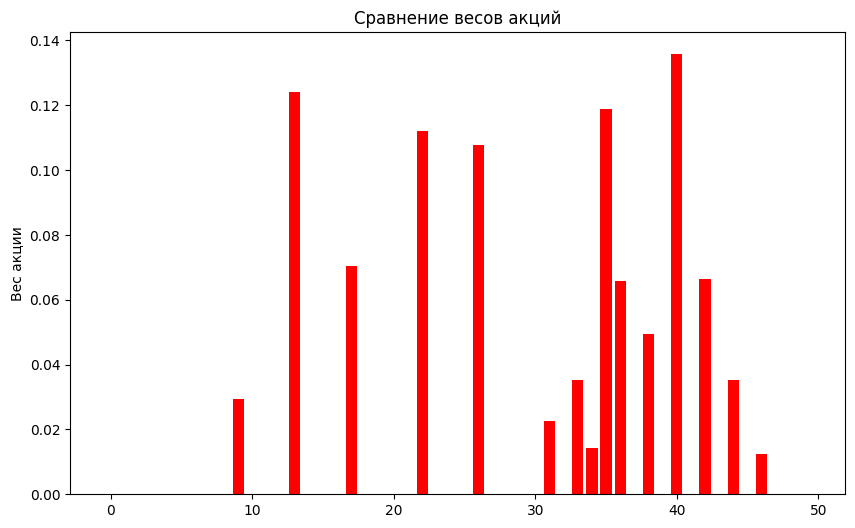

In [ ]:
create_bar_graph_weight(weights_min_risk_no_short)

Сравниваем оба портфеля по риску:

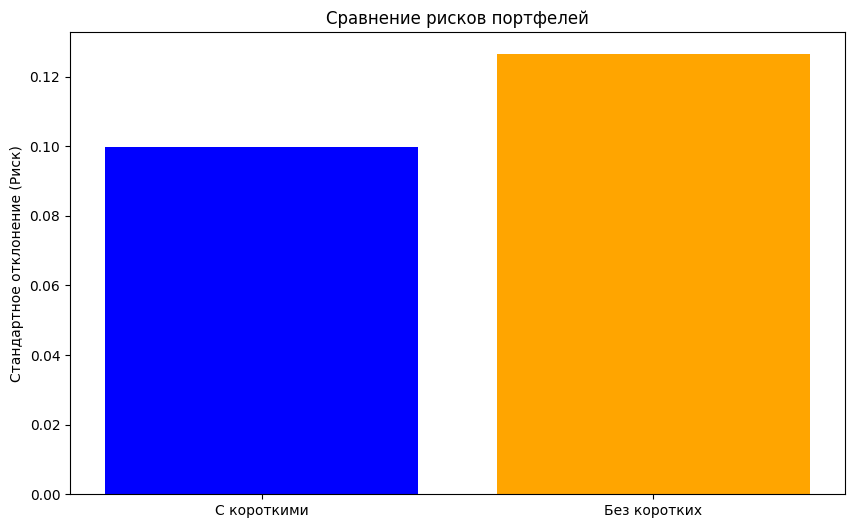

In [ ]:
def create_bar_graph_risks(risk_no_short, risk_short):
    plt.figure(figsize=(10, 6))
    plt.bar(['С короткими', 'Без коротких'], [risk_short, risk_no_short], color=['blue', 'orange'])
    plt.title('Сравнение рисков портфелей')
    plt.ylabel('Стандартное отклонение (Риск)')
    plt.show()


create_bar_graph_risks(port_min_risk_vol_no_short, port_min_risk_vol_short)

Визуализируем «карту» активов в системе координат (σ, E):

In [ ]:
def create_portfolio_graph(risk_short, mean_short, risk_no_short, mean_no_short, returns_file):
    fig, ax = plt.subplots()
    ax.scatter(
        risk_short,
        mean_short,
        marker='o',
        color='blue',
        s=80,  # Размер маркера
        label='short'
    )

    ax.scatter(
        risk_no_short,
        mean_no_short,
        marker='o',
        color='green',
        s=80,
        label='no_short'
    )

    # Портфель с равными долями акций
    returns = pd.read_excel(returns_file)
    num_assets = len(returns.columns)
    weights = np.ones(num_assets) / num_assets
    print(weights)
    port_return, port_vol, sharpe = portfolio(weights, returns_file)
    ax.scatter(
        port_vol,
        port_return,
        marker='o',
        color='purple',
        s=80,  # Размер маркера
        label='Равные доли вложения'
    )

    plt.title('Сравнение портфелей')
    plt.legend()
    plt.ylabel('mean')
    plt.xlabel('var')
    plt.show()

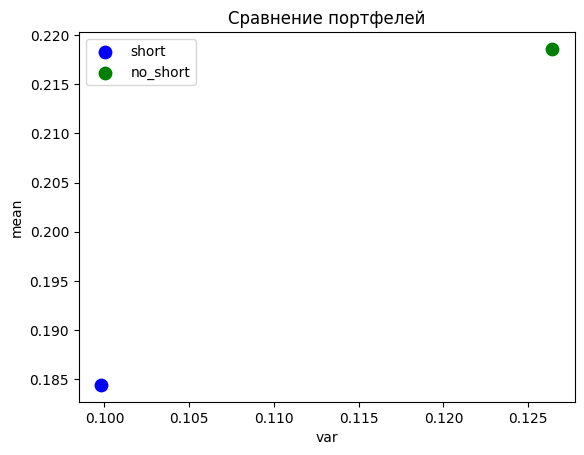

In [ ]:
create_portfolio_graph(port_min_risk_vol_short, port_min_risk_return_short, port_min_risk_vol_no_short, port_min_risk_return_no_short)

ВЫВОД: Портфель с разрешением коротких продаж состоит из 15 активов и имеет значительно меньший риск (0.099), но при этом и меньшую доходность (0.184).
Портфель с запретом коротких продаж состоит из всех 50 активов, он более рискованный (0.126), но обеспечивает большую доходность (0.219).
Коэффициент Шарпа у 1го портфеля - 1.847, у 2го - 1.729.
Это значит, что портфель с разрешением коротких продаж доходнее на единицу риска.


# Эффективный фронт

 Эффективная граница — это кривая, представляющая наилучшие портфели с точки зрения доходности и риска. Портфели на этой границе либо с максимизированной доходностью при заданном уровне риска, либо с минимизированным риском при заданной доходности.

Вычисляем эффективную границу для портфеля с разрешением коротких продаж:

In [ ]:
def efficient_frontier_short(cov_file, mv_file, ef_short_file):
    if not os.path.exists(ef_short_file) or os.stat(ef_short_file).st_size == 0:
        returns = pd.read_excel(mv_file)
        cov = pd.read_excel(cov_file)
        ef = EfficientFrontier(returns['Мат ожидание'], cov, weight_bounds=(-1, 1))
        minvol = ef.min_volatility() # поиск портфеля с минимальным риском
        weights = ef.clean_weights() # убираем очень маленькие веса
        res = pd.DataFrame()
        res['ticket'] = returns['Название акции']
        res['weights'] = weights
        res.to_excel(ef_short_file)


ef_short_file50='data2/ef_short.xlsx'
efficient_frontier_short(cov_file50,mean_var50,ef_short_file50)

Вычисляем эффективную границу для портфеля с запретом коротких продаж:

In [ ]:
def efficient_frontier_no_short(cov_file, mv_file, ef_no_short_file):
    if not os.path.exists(ef_no_short_file) or os.stat(ef_no_short_file).st_size == 0:
        returns = pd.read_excel(mv_file)
        cov = pd.read_excel(cov_file)
        ef = EfficientFrontier(returns['Мат ожидание'], cov, weight_bounds=(0, 1))
        minvol = ef.min_volatility()
        weights = ef.clean_weights()
        res = pd.DataFrame()
        res['ticket'] = returns['Название акции']
        res['weights'] = weights
        res.to_excel(ef_no_short_file)


ef_no_short_file50 = 'data2/ef_no_short.xlsx'
efficient_frontier_no_short(cov_file50, mean_var50, ef_no_short_file50)

Визуализируем оба фронта и карту активов в системе координат (σ, E):

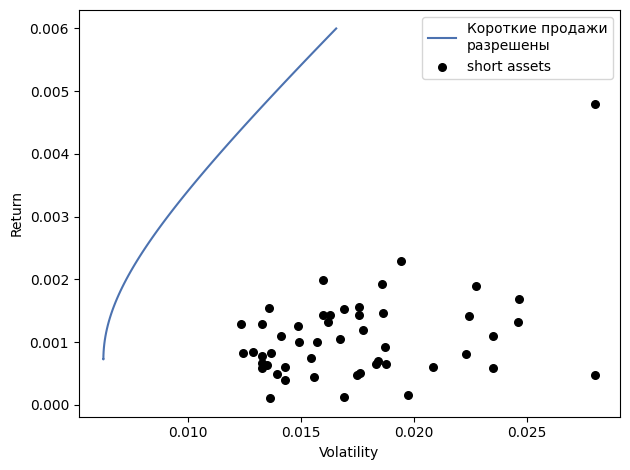

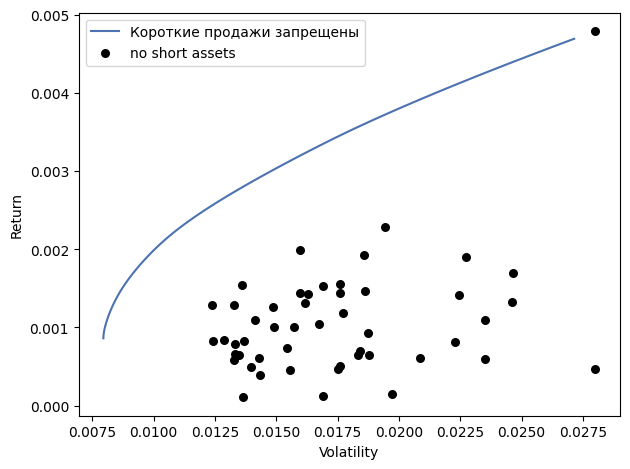

In [ ]:
def efficient_frontier(cov_file, mv_file):
    returns = pd.read_excel(mv_file)
    cov = pd.read_excel(cov_file)
    fig, ax = plt.subplots()
    ef = EfficientFrontier(returns['Мат ожидание'], cov, weight_bounds=(-1, 1))
    plotting.plot_efficient_frontier(ef, ax=ax, ef_param_range=np.linspace(0.00, 0.006, 100), c='blue', )
    plt.legend(['Короткие продажи\nразрешены', 'short assets'])
    plt.show()
    fig, ax = plt.subplots()
    ef = EfficientFrontier(returns['Мат ожидание'], cov, weight_bounds=(0, 1))
    plotting.plot_efficient_frontier(ef, ax=ax, c='green')
    plt.legend(['Короткие продажи запрещены', 'no short assets'])
    plt.show()


efficient_frontier(cov_file50, mean_var50)

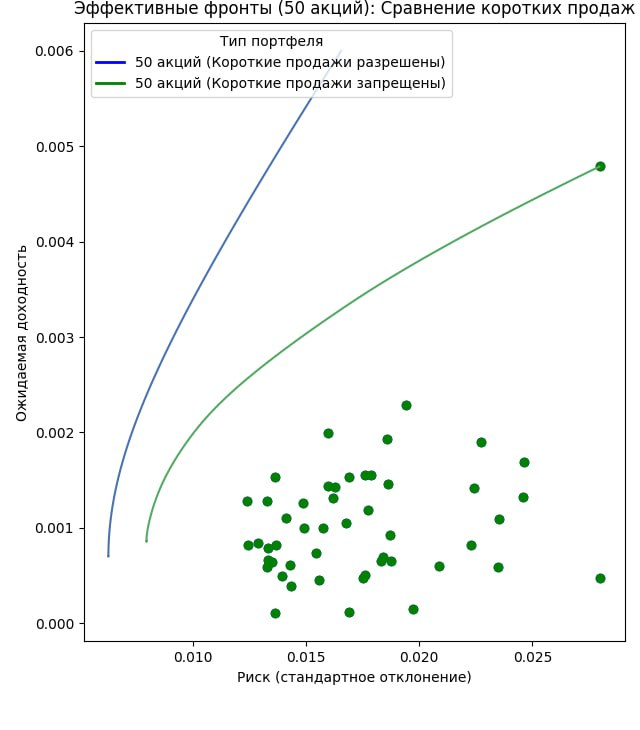

ВЫВОД: В случае разрешенных коротких продаж эффективная граница располагается выше и имеет более выпуклую форму, что предполагает больше возможностей для оптимизации портфеля, например  достижения более высокой доходности при той же волатильности.


Рассматриваем портфель с равными долями вложений капитала относительно полученных портфелей:

In [ ]:
def plot_stocks(returns, cov, ax, color):
    ax.scatter(np.sqrt(np.diag(cov)), returns['Мат ожидание'], color=color)

In [ ]:
def plot_efficient_frontier(returns, cov, color, label, ax, weight_bounds):
    ef = EfficientFrontier(returns, cov, weight_bounds=weight_bounds)
    plotting.plot_efficient_frontier(ef, ax=ax, ef_param_range=np.linspace(0.00, 0.006, 100), c=color)
    return ef

In [ ]:
def compare_efficient_frontiers_50_short_vs_no_short(cov_file_50, mv_file_50, returns_file):
    returns_full = pd.read_excel(mv_file_50)
    cov_full = pd.read_excel(cov_file_50)

    fig, ax = plt.subplots()

    # Эффективный фронт с короткими продажами (50 акций)
    ef_50_short = plot_efficient_frontier(returns_full['Мат ожидание'], cov_full, color='blue',
                                          label='50 акций (Короткие продажи разрешены)', ax=ax, weight_bounds=(-1, 1))
    plot_stocks(returns_full, cov_full, ax, color='blue')

    # Эффективный фронт без коротких продаж (50 акций)
    ef_50_no_short = plot_efficient_frontier(returns_full['Мат ожидание'], cov_full, color='green',
                                             label='50 акций (Короткие продажи запрещены)', ax=ax, weight_bounds=(0, 1))
    plot_stocks(returns_full, cov_full, ax, color='green')

    # Портфель с равными весами
    num_assets = len(cov_full)
    weights = np.ones(num_assets) / num_assets
    port_return, port_vol, sharpe = portfolio(weights, returns_file)
    ax.scatter(
        port_vol,
        port_return,
        marker='o',
        color='purple',
        s=80,
        label='Равные доли вложения'
    )

    plt.title('Эффективные фронты (50 акций)')
    plt.xlabel('Риск (стандартное отклонение)')
    plt.ylabel('Ожидаемая доходность')

    lines = [plt.Line2D([0], [0], color='blue', lw=2),
             plt.Line2D([0], [0], color='green', lw=2)]
    plt.legend(lines, ['50 акций (Короткие продажи разрешены)', '50 акций (Короткие продажи запрещены)'],
               title='Тип портфеля', loc='upper left')

    plt.show()


[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]


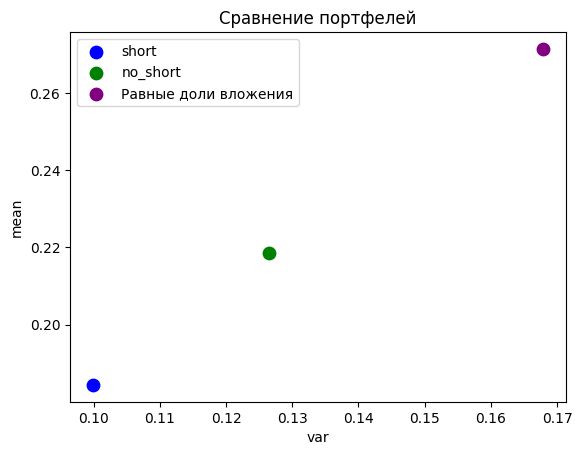

In [ ]:
create_portfolio_graph(port_min_risk_vol_short, port_min_risk_return_short, port_min_risk_vol_no_short, port_min_risk_return_no_short, pr_file50)


В сравнении с портфелями, полученными в результате оптимизации, данный портфель имеют большую доходность и волатильность.

/usr/local/lib/python3.10/dist-packages/pypfopt/plotting.py:190: UserWarning: Could not construct portfolio for parameter value 0.005
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pypfopt/plotting.py:190: UserWarning: Could not construct portfolio for parameter value 0.006
  warnings.warn(


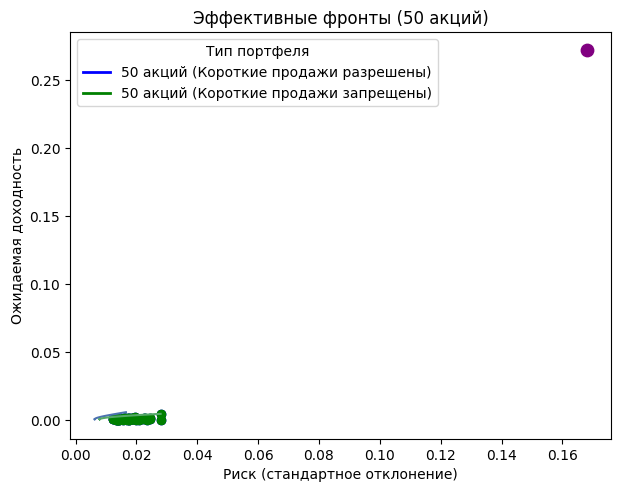

In [ ]:
compare_efficient_frontiers_50_short_vs_no_short(cov_file50, mean_var50, pr_file50)

ВЫВОД: Портфель с равными долями вложения капитала обладает гораздо большей доходностью, чем оба эффективных фронта, но также сопровождается значительно более высоким риском. Данный портфель с равными долями вложения капитала не является оптимальным, так как он далеко выходит за пределы эффективных фронтов.

# «Хорошие» инвестиционные портфели

Выбираем 10 акции с наилучшими весами на основе модели Марковица:

In [ ]:
def portfolio_optimization(mean_returns, cov_matrix, target_return):
    num_assets = len(mean_returns)
    weights = np.ones(num_assets) / num_assets # задаем равные веса

    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, # сумма весов = 1
                   {'type': 'eq', 'fun': lambda weights: np.dot(weights, mean_returns) - target_return}) # доходность = предельной

    bounds = tuple((-1, 1) for asset in range(num_assets))

    # минимизируем волатильность портфеля
    result = minimize(portfolio_volatility, weights, method='SLSQP', bounds=bounds, constraints=constraints)

    return result



In [ ]:
def find_10stocks(tickets_file10, mean_var50, stocks_file50, pr_file50, stocks_file10, pr_file10, mean_var10,
                  cov_matrix,
                  target_return=0.05):
    if not os.path.exists(tickets_file10) or os.stat(tickets_file10).st_size == 0:
        df = pd.read_excel(mean_var50)
        mean_returns = df['Мат ожидание'].values

        cov_matrix = pd.read_excel(cov_matrix).values

        optimal_portfolio = portfolio_optimization(mean_returns, cov_matrix, target_return)
        selected_stocks = df['Название акции'].iloc[optimal_portfolio['x'].argsort()[-10:]].values #10 акций с наибольшими весами
        save_names_to_file(selected_stocks, tickets_file10)

    top_10 = get_names_from_file(tickets_file10)

    if not os.path.exists(stocks_file10) or os.stat(stocks_file10).st_size == 0:
        df2 = pd.read_excel(stocks_file50)
        columns = df2.columns[df2.columns.isin(top_10)]
        df2 = df2[columns]
        df2.to_excel(stocks_file10, index=False)

    if not os.path.exists(pr_file10) or os.stat(pr_file10).st_size == 0:
        df2 = pd.read_excel(pr_file50)
        columns = df2.columns[df2.columns.isin(top_10)]
        df2 = df2[columns]
        df2.to_excel(pr_file10, index=False)

    if not os.path.exists(mean_var10) or os.stat(mean_var10).st_size == 0:
        df2 = pd.read_excel(mean_var50)
        df2 = df2[df2['Название акции'].isin(top_10)]
        df2.to_excel(mean_var10, index=False)

    print(len(get_names_from_file(tickets_file10)))

tickets_file10 = 'data2/tickets10.txt'
stocks_file10 = 'data2/stocks10.xlsx'
pr_file10 = 'data2/profitability10.xlsx'
mean_var10 = 'data2/mean_var10.xlsx'


find_10stocks(tickets_file10, mean_var50, stocks_file50, pr_file50, stocks_file10, pr_file10, mean_var10,
                  cov_file50)


10


Вычисляем ковариационную матрицу:

In [ ]:
cov_file10 = 'data2/cov_file10.xlsx'

calculate_cov(pr_file10, cov_file10)

Сравниваем эффективные фронты:

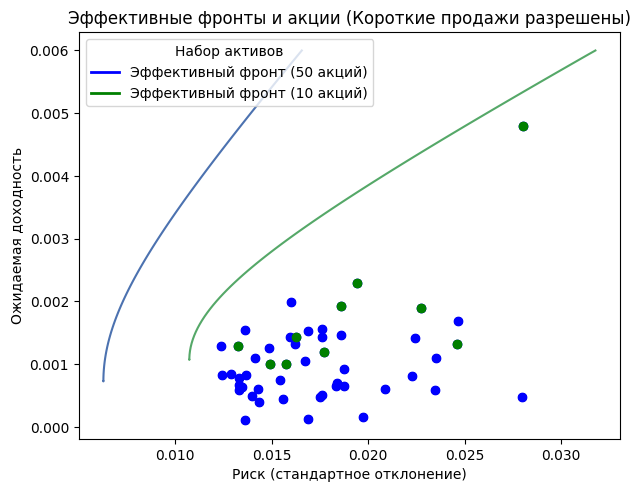

/usr/local/lib/python3.10/dist-packages/pypfopt/plotting.py:190: UserWarning: Could not construct portfolio for parameter value 0.005
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pypfopt/plotting.py:190: UserWarning: Could not construct portfolio for parameter value 0.006
  warnings.warn(


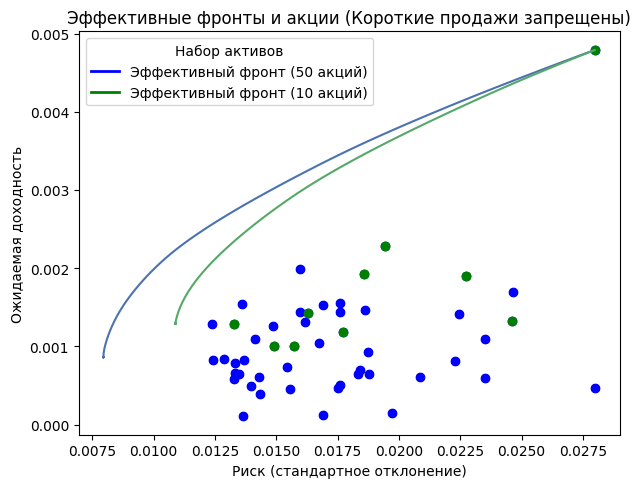

In [ ]:
def compare_efficient_frontiers(cov_file_50, mv_file_50, cov_file_10, mv_file_10):
    returns_full = pd.read_excel(mv_file_50)
    cov_full = pd.read_excel(cov_file_50)

    returns_selected = pd.read_excel(mv_file_10)
    cov_selected = pd.read_excel(cov_file_10)

    fig, ax = plt.subplots()

    # Эффективный фронт с короткими продажами (50 акций)
    ef_50 = plot_efficient_frontier(returns_full['Мат ожидание'], cov_full, color='blue',
                                    label='50 акций (Короткие продажи разрешены)', ax=ax, weight_bounds=(-1, 1))
    plot_stocks(returns_full, cov_full, ax, color='blue')
    # Эффективный фронт с короткими продажами (10 акций)
    ef_10 = plot_efficient_frontier(returns_selected['Мат ожидание'], cov_selected, color='green',
                                    label='10 акций (Короткие продажи разрешены)', ax=ax, weight_bounds=(-1, 1))
    plot_stocks(returns_selected, cov_selected, ax, color='green')

    plt.title('Эффективные фронты и акции (Короткие продажи разрешены)')
    plt.xlabel('Риск (стандартное отклонение)')
    plt.ylabel('Ожидаемая доходность')

    lines = [plt.Line2D([0], [0], color='blue', lw=2),
             plt.Line2D([0], [0], color='green', lw=2)]
    plt.legend(lines, ['Эффективный фронт (50 акций)', 'Эффективный фронт (10 акций)'], title='Набор активов',
               loc='upper left')

    plt.show()

    fig, ax = plt.subplots()
    # Эффективный фронт без коротких продаж (50 акций)
    ef_50_no_short = plot_efficient_frontier(returns_full['Мат ожидание'], cov_full, color='blue',
                                             label='50 акций (Короткие продажи запрещены)', ax=ax, weight_bounds=(0, 1))
    plot_stocks(returns_full, cov_full, ax, color='blue')

    # Эффективный фронт без коротких продаж (10 акций)
    ef_10_no_short = plot_efficient_frontier(returns_selected['Мат ожидание'], cov_selected, color='green',
                                             label='10 акций (Короткие продажи запрещены)', ax=ax, weight_bounds=(0, 1))
    plot_stocks(returns_selected, cov_selected, ax, color='green')

    plt.title('Эффективные фронты и акции (Короткие продажи запрещены)')
    plt.xlabel('Риск (стандартное отклонение)')
    plt.ylabel('Ожидаемая доходность')

    plt.legend(lines, ['Эффективный фронт (50 акций)', 'Эффективный фронт (10 акций)'], title='Набор активов',
               loc='upper left')

    plt.show()


ef_short_file10 = 'data2/ef_short.xlsx'
ef_no_short_file10 = 'data2/ef_no_short.xlsx'

compare_efficient_frontiers(cov_file50, mean_var50, cov_file10, mean_var10)

ВЫВОД:

*   Когда короткие продажы разрешены эффективный фронт для 50 акций демонстрирует значительные преимущества по сравнению с фронтом 10 акций, предлагая лучшие возможности для оптимизации портфеля и более широкий спектр инвестиционных стратегий.
*   Когда короткие продажи запрещены границы не сильно отличаются друг от друга, однако фронт для 50 акций обеспечивает больше возможностей для формирования портфеля, включая варианты с меньшим риском.




# Отношение к риску

Мы относимся к риску с высокой степенью уверенности и готовности, что обусловлено рядом факторов, которые позволяют нам принимать смелые решения. Во-первых, отсутствие детей и семейных обязательств дает нам гибкость в управлении нашими финансами.
Кроме того, наличие подушки безопасности служит дополнительным фактором, обостряющим наше восприятие риска.
Таким образом, более высокий риск воспринимается нами как часть стратегии, ведущей к динамизированному росту и достижению амбициозных целей.
Выбрали значение risk_aversion = 0.3


## Построим личный оптимальный портфель инвестиций из выбранных 50 активов с разрешением коротких продаж.

In [ ]:
def opt_port_with_risk_aversion_short(cov_file, mv_file, port_risk_av_short_file, risk_aversion=1):
    if not os.path.exists(port_risk_av_short_file) or os.stat(port_risk_av_short_file).st_size == 0:
        returns = pd.read_excel(mv_file)
        cov = pd.read_excel(cov_file)
        ef = EfficientFrontier(returns['Мат ожидание'], cov, weight_bounds=(-1, 1))
        minvol = ef.max_quadratic_utility(risk_aversion=risk_aversion)
        weights = ef.clean_weights()
        res = pd.DataFrame()
        res['ticket'] = returns['Название акции']
        res['weights'] = weights
        res.to_excel(port_risk_av_short_file)
    print(pd.read_excel(port_risk_av_short_file))


def opt_port_with_risk_aversion_no_short(cov_file, mv_file, port_risk_av_no_short_file, risk_aversion=1):
    if not os.path.exists(port_risk_av_no_short_file) or os.stat(port_risk_av_no_short_file).st_size == 0:
        returns = pd.read_excel(mv_file)
        cov = pd.read_excel(cov_file)
        ef = EfficientFrontier(returns['Мат ожидание'], cov, weight_bounds=(0, 1))
        minvol = ef.max_quadratic_utility(risk_aversion=risk_aversion)
        weights = ef.clean_weights()
        res = pd.DataFrame()
        res['ticket'] = returns['Название акции']
        res['weights'] = weights
        res.to_excel(port_risk_av_no_short_file)
    print(pd.read_excel(port_risk_av_no_short_file))


In [ ]:
port_risk_av_short_file = 'data2/port_risk_av_short.xlsx'
port_risk_av_no_short_file = 'data2/port_risk_av_no_short.xlsx'
opt_port_with_risk_aversion_short(cov_file50, mean_var50, port_risk_av_short_file, 0.3)

    Unnamed: 0 ticket  weights
0            0   NVDA  1.00000
1            1   MSFT -1.00000
2            2   AMZN -1.00000
3            3   META -1.00000
4            4   AVGO -0.48183
5            5   ASML  1.00000
6            6   NFLX -1.00000
7            7   TMUS  1.00000
8            8   ADBE -1.00000
9            9   CSCO -1.00000
10          10   QCOM  1.00000
11          11    TXN  1.00000
12          12   INTU -1.00000
13          13   ISRG -1.00000
14          14   AMAT  1.00000
15          15   BKNG -1.00000
16          16    ADI  1.00000
17          17   KLAC -1.00000
18          18   LRCX  1.00000
19          19   MELI  1.00000
20          20   INTC -1.00000
21          21   MDLZ -1.00000
22          22   CTAS  1.00000
23          23   PYPL -1.00000
24          24   CDNS -1.00000
25          25    MAR  0.87257
26          26   ORLY -1.00000
27          27    CSX  1.00000
28          28   MRVL  1.00000
29          29   NXPI -1.00000
30          30   ADSK -1.00000
31      

* Акция NVDA имеет максимальный положительный вес (1.00000), что означает, что в неё вложен весь капитал для длинной позиции.
* Акции вроде MSFT, AMZN, и другие имеют вес -1.00000, что говорит о полной короткой позиции по этим активам.
* Некоторые активы, такие как AVGO и KHC, имеют дробные веса (-0.48183 и 0.62558), что означает частичное вложение или короткую позицию в этих акциях.

Оценим VaR и CvaR доходностей этого портфеля.

In [ ]:
def value_at_risk(returns_file, weights, alpha=0.95, lookback_days=250, value_invested=1):
    returns = pd.read_excel(returns_file)
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days].dot(weights)
    return np.percentile(portfolio_returns, 100 * (1 - alpha)) * value_invested


def cond_value_at_risk(returns_file, weights, alpha=0.95, lookback_days=250, value_invested=1):
    var = value_at_risk(returns_file, weights, alpha, lookback_days, value_invested)
    returns = pd.read_excel(returns_file)
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    var_pct_loss = var / value_invested
    return np.nanmean(portfolio_returns[portfolio_returns < var_pct_loss]) * value_invested


def show_var_cvar_graph(returns_file, weights, alpha=0.95, lookback_days=250, value_invested=1):
    returns = pd.read_excel(returns_file)
    # print("Shape of returns:", returns.shape)
    # print("Shape of weights:", weights.shape)
    weights = weights.values.flatten()
    # print(weights)
    portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

    portfolio_VaR = value_at_risk(returns_file, weights, alpha, lookback_days, value_invested)
    portfolio_VaR_return = portfolio_VaR / value_invested

    portfolio_CVaR = cond_value_at_risk(returns_file, weights, alpha, lookback_days, value_invested)
    portfolio_CVaR_return = portfolio_CVaR / value_invested


    print('VaR:', portfolio_VaR_return,'CVaR:', portfolio_CVaR_return)
    plt.hist(portfolio_returns[portfolio_returns > portfolio_VaR_return], bins=20)
    plt.hist(portfolio_returns[portfolio_returns < portfolio_VaR_return], bins=10)
    plt.axvline(portfolio_VaR_return, color='red', linestyle='solid')
    plt.axvline(portfolio_CVaR_return, color='red', linestyle='dashed')
    plt.legend(['VaR', 'CVaR', 'Returns', 'Returns < VaR'])
    plt.title('Historical VaR and CVaR')
    plt.xlabel('Return')
    plt.ylabel('Observation Frequency')
    plt.show()

VaR: -0.37812803240461745 CVaR: -0.3781280324046175


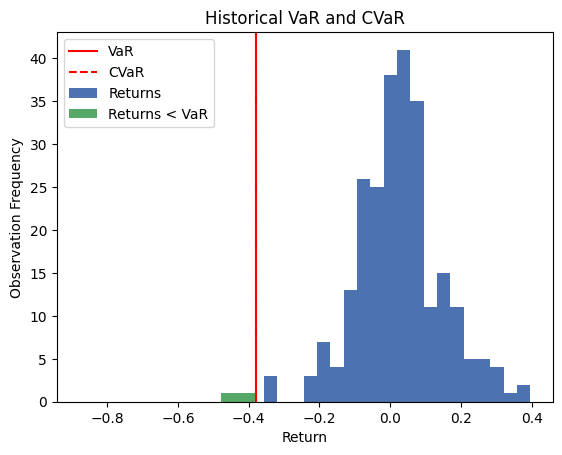

In [ ]:
weights_short = pd.read_excel(port_risk_av_short_file)['weights']
show_var_cvar_graph(pr_file50, weights_short)

С вероятностью 95% мы не потеряем больше чем 37.8% вложений.
И с вероятностью 5% средняя потеря сотавит 37.8% вложений.

## Построим личный оптимальный портфель инвестиций из выбранных 50 активов с запретом коротких продаж.

In [ ]:
opt_port_with_risk_aversion_no_short(cov_file50, mean_var50, port_risk_av_no_short_file, 0.3)

    Unnamed: 0 ticket  weights
0            0   NVDA        1
1            1   MSFT        0
2            2   AMZN        0
3            3   META        0
4            4   AVGO        0
5            5   ASML        0
6            6   NFLX        0
7            7   TMUS        0
8            8   ADBE        0
9            9   CSCO        0
10          10   QCOM        0
11          11    TXN        0
12          12   INTU        0
13          13   ISRG        0
14          14   AMAT        0
15          15   BKNG        0
16          16    ADI        0
17          17   KLAC        0
18          18   LRCX        0
19          19   MELI        0
20          20   INTC        0
21          21   MDLZ        0
22          22   CTAS        0
23          23   PYPL        0
24          24   CDNS        0
25          25    MAR        0
26          26   ORLY        0
27          27    CSX        0
28          28   MRVL        0
29          29   NXPI        0
30          30   ADSK        0
31      

In [ ]:
print(pd.read_excel(mean_var50).head(1))

  Название акции  Мат ожидание  Дисперсия
0           NVDA      0.004792   0.000781


Из - за того что выбрали высокий риск профиль, а акции NVDA имеют наиболее высокую ожидаемую доходность, доли капиталовложений в портфеле уходят полностью на покупку акции от NVDA.

VaR: -0.04222915734139075 CVaR: -0.053638962723341434


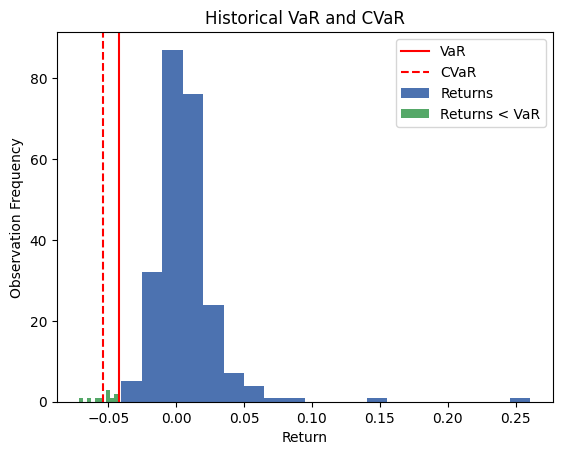

In [ ]:
weights_no_short = pd.read_excel(port_risk_av_no_short_file)['weights']
show_var_cvar_graph(pr_file50, weights_no_short)

С вероятностью 95% мы не потеряем больше чем 4.22% вложений.
И с вероятностью 5% средняя потеря сотавит 5.36% вложений.

В случае запрета коротких продаж с выбранным риск профилем портфель является более надёжным с меньшей волатильностью.

In [ ]:
def efficient_frontier_4num(cov_file, mv_file, returns_file, weights1_file, weights2_file):
    returns = pd.read_excel(mv_file)
    cov = pd.read_excel(cov_file)
    fig, ax = plt.subplots()
    ef = EfficientFrontier(returns['Мат ожидание'], cov, weight_bounds=(-1, 1))
    plotting.plot_efficient_frontier(ef, ax=ax, ef_param_range=np.linspace(0.00, 0.006, 100), c='blue', )

    weights1 = pd.read_excel(weights1_file)['weights']
    port_return, port_vol, sharpe = portfolio(weights1, returns_file)
    ax.scatter(
        port_vol,
        port_return,
        marker='o',
        color='purple',
        s=80,  # Размер маркера
        label='with risk aversion'
    )

    plt.legend(['Короткие продажи\nразрешены', 'short assets'])
    plt.show()

    fig, ax = plt.subplots()
    ef = EfficientFrontier(returns['Мат ожидание'], cov, weight_bounds=(0, 1))
    plotting.plot_efficient_frontier(ef, ax=ax, c='green')

    weights2 = pd.read_excel(weights2_file)['weights']
    port_return, port_vol, sharpe = portfolio(weights2, returns_file)
    ax.scatter(
        port_vol,
        port_return,
        marker='o',
        color='purple',
        s=80,  # Размер маркера
        label='with risk aversion'
    )

    plt.legend(['Короткие продажи запрещены', 'no short assets'])
    plt.show()

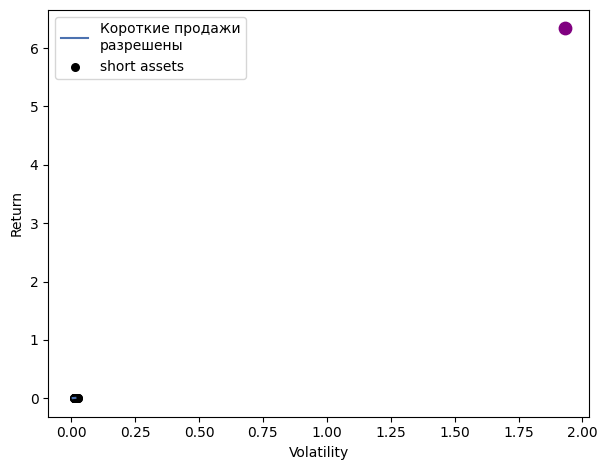

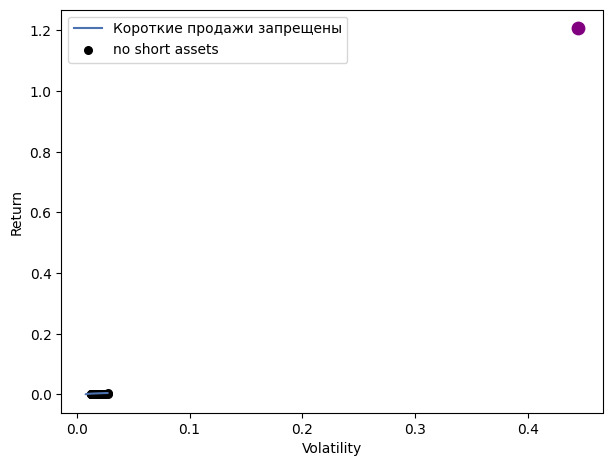

In [ ]:
efficient_frontier_4num(cov_file50, mean_var50, pr_file50, port_risk_av_short_file, port_risk_av_no_short_file)

In [56]:
mean_short, var_short, sharp_short = portfolio(pd.read_excel(port_risk_av_short_file)['weights'], pr_file50)
print(mean_short, var_short, sharp_short)

6.335903104630313 1.930867315703071 3.281376743550746


In [57]:
mean_no_short, var_no_short, sharp_no_short = portfolio(pd.read_excel(port_risk_av_no_short_file)['weights'], pr_file50)
print(mean_no_short, var_no_short, sharp_no_short)

1.2075226287336962 0.44460825715129654 2.7159248828858034


Вывод: Этот портфель, с заданным уровнем риска, демонстрирует значительно более высокую доходность по сравнению с эффективным фронтом, как в условиях разрешённых коротких продаж, так и без них. Однако это также связано с существенно большим риском. Портфель с заданным уровнем риска не является оптимальным, поскольку его показатели значительно превышают границы эффективного фронта.

Также портфель с разрешением коротких продаж имеет больше доходность при большей волатильности, но коэффициент Шарпа также выше чем у портфеля с запретом коротких продаж.